# _r/depression Text Analysis_

## Text analysis of r/depression's top 1000 posts of 'all time'. 

## Contents:
### 1. 제목에서 자주 쓰인 단어 시각화
### 2. 글의 비지도학습 기반 감정분석
### 3-1. 문서 군집화(Document Clustering)
### 3-2. 군집별 핵심 단어 추출

![](image.png)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings(action='ignore')

In [2]:
import praw  #Reddit API used for scraping Reddit

In [3]:
import datetime as dt

import nltk #used for preprocessing texts
from nltk import word_tokenize #for Word Tokenization

import re #for text cleansing
import string

from wordcloud import WordCloud, ImageColorGenerator #for wordcloud

import collections #for counting words

from nltk.sentiment.vader import SentimentIntensityAnalyzer #for sentiment analysis

from sklearn.feature_extraction.text import TfidfVectorizer #문서를 TF-IDF형태로 피처 벡터화하기 위함

# _Importing data_

### reddit api를 이용하자

In [5]:
reddit = praw.Reddit(client_id=client_id, client_secret=client_secret, user_agent=user_agent)

In [6]:
subreddit = reddit.subreddit('depression')

In [7]:
top_subreddit = subreddit.top(limit=1000) #Reddit only allows max of 1000 posts to scrape

### subreddit.top 는 시점이 'All Time'인 'Top' posts들을 준다

In [8]:
#for checking
for submission in subreddit.top(limit=5):
    print(submission.title,end='\n\n')

Depression for me is a constant feeling of wanting to go home, but no matter where I am, I am never home. Even when I’m at my physical home.

Depression is so much worse if you live with your parents.

Shout out to the particular hell that is functional depression.

A stranger just saved my life...

I was going to kill myself tonight



### 데이터 스크레이핑(Scraping): 'All time'시점의 1000개의 'Top' posts

In [9]:
#dictionary to store the data
data_dict = {"title":[], "body":[], "created": []}

In [10]:
for submission in top_subreddit:
    data_dict["title"].append(submission.title)
    data_dict["body"].append(submission.selftext)
    data_dict["created"].append(submission.created)

In [11]:
df = pd.DataFrame(data_dict)

### 불러온 데이터

In [12]:
df.head()

,title,body,created
0,Depression for me is a constant feeling of wan...,It’s a constant sense of wanting to go somewhe...,1.565672e+09
1,Depression is so much worse if you live with y...,"I can't hide, I can't cry out loud, they don't...",1.560972e+09
2,Shout out to the particular hell that is funct...,"This is me. Don’t get me wrong, it’s better th...",1.563120e+09
3,A stranger just saved my life...,I woke up today wanting to die. I was planning...,1.513392e+09
4,I was going to kill myself tonight,I wrote a suicide note earlier in the morning....,1.558794e+09


# _Data(Text) 전처리_

### 'created'는 글이 쓰여진 날짜와 시간을 UNIX timestamp으로 나타낸 것이다. 이를 적절히 알아 볼 수 있는 형태로 바꿔보자.

[source](https://www.storybench.org/how-to-scrape-reddit-with-python/)

In [13]:
def get_date(created):
    return dt.datetime.fromtimestamp(created)

In [14]:
_timestamp = df["created"].apply(get_date)

In [15]:
df = df.assign(timestamp = _timestamp)
df

,title,body,created,timestamp
0,Depression for me is a constant feeling of wan...,It’s a constant sense of wanting to go somewhe...,1.565672e+09,2019-08-13 13:50:20
1,Depression is so much worse if you live with y...,"I can't hide, I can't cry out loud, they don't...",1.560972e+09,2019-06-20 04:25:08
2,Shout out to the particular hell that is funct...,"This is me. Don’t get me wrong, it’s better th...",1.563120e+09,2019-07-15 00:53:40
3,A stranger just saved my life...,I woke up today wanting to die. I was planning...,1.513392e+09,2017-12-16 11:40:29
4,I was going to kill myself tonight,I wrote a suicide note earlier in the morning....,1.558794e+09,2019-05-25 23:16:10
...,...,...,...,...
964,Have you ever felt so sad that you actually fe...,I feel so stupid. And so worthless. I feel lik...,1.526727e+09,2018-05-19 19:53:58
965,anyone else here have no real hobbies/goals/in...,,1.499429e+09,2017-07-07 20:55:24
966,I don’t know if i’m still depressed. I don’t f...,I can almost feel pain and numbness creeping i...,1.525816e+09,2018-05-09 06:52:03
967,Yesterday I finally went to the doctors to spe...,He has diagnosed me with depression and given ...,1.563403e+09,2019-07-18 07:29:30


In [16]:
#Let's get rid of 'created' column because it is no longer needed.
df = df.drop(['created'], axis = 1)

In [17]:
df.head()

,title,body,timestamp
0,Depression for me is a constant feeling of wan...,It’s a constant sense of wanting to go somewhe...,2019-08-13 13:50:20
1,Depression is so much worse if you live with y...,"I can't hide, I can't cry out loud, they don't...",2019-06-20 04:25:08
2,Shout out to the particular hell that is funct...,"This is me. Don’t get me wrong, it’s better th...",2019-07-15 00:53:40
3,A stranger just saved my life...,I woke up today wanting to die. I was planning...,2017-12-16 11:40:29
4,I was going to kill myself tonight,I wrote a suicide note earlier in the morning....,2019-05-25 23:16:10


### Text Cleansing

#### 1. 모든 글자들을 소문자로 바꾸자

In [18]:
for i in range(len(df)):
    df['title'][i] = df['title'][i].lower()
    df['body'][i] = df['body'][i].lower()

#### 2. regular expressions를 이용해 기호들을 제거하자

In [19]:
for i in range(len(df)):
    df['title'][i] = re.sub("[^-9A-Za-z ]", "" , df['title'][i])
    df['body'][i] = re.sub("[^-9A-Za-z ]", "" , df['body'][i])

## Final model

In [20]:
df.head()

,title,body,timestamp
0,depression for me is a constant feeling of wan...,its a constant sense of wanting to go somewher...,2019-08-13 13:50:20
1,depression is so much worse if you live with y...,i cant hide i cant cry out loud they dont unde...,2019-06-20 04:25:08
2,shout out to the particular hell that is funct...,this is me dont get me wrong its better than d...,2019-07-15 00:53:40
3,a stranger just saved my life,i woke up today wanting to die i was planning ...,2017-12-16 11:40:29
4,i was going to kill myself tonight,i wrote a suicide note earlier in the morning ...,2019-05-25 23:16:10


## 1. 제목에서 자주 쓰인 단어 시각화

### Word Tokenization

In [21]:
words = []

for title in df['title']:
    for word in word_tokenize(title):
        words.append(word)

In [22]:
len(words) #Total amount of words

13579

### Deleting Stopwords

In [23]:
stopwords = nltk.corpus.stopwords.words('english')
filtered_words = []

In [24]:
for word in words:
    if word not in stopwords:
        filtered_words.append(word)

In [25]:
len(filtered_words) #Total amount of words after filtering stopwords

7157

## WordCloud로 시각화

In [26]:
#Need to join all the words from the filtered words with a space inbetween. Ex: depression constant feeling ...
#This is required to build the text corpus which will be used to build the word cloud.

words_for_wordcloud = ""
for word in filtered_words:
    words_for_wordcloud = words_for_wordcloud + word + " "

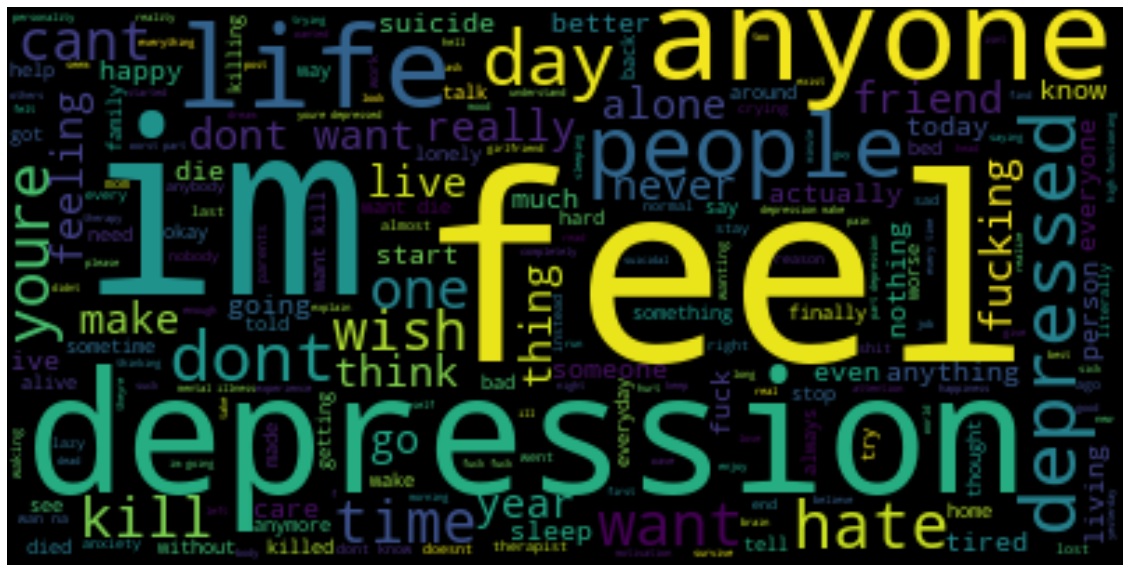

In [27]:
wordcloud_for_title = WordCloud(random_state=0).generate(words_for_wordcloud)

plt.figure(figsize = (20,20))
plt.imshow(wordcloud_for_title, interpolation='bilinear')
plt.axis("off")
plt.show()

#### 여기서 보이는 단어들로 'depressive indicative words'를 구축할 때 어느정도 필터링도 필요할 것으로 보이긴 한다. 예를 들어, 'go'나 'going' 'youre' 등은 의미가 있을지 잘 모르겠다.

In [28]:
filter_these = ['go','going','youre','im','ive','thing','around','actually','really',
                'one','really','even','much','else','ever']
for item in filter_these:
    stopwords.append(item)

### 새롭게 필터링된 단어들로 다시 시각화하자

In [29]:
filtered_words = []

In [30]:
for word in words:
    if word not in stopwords:
        filtered_words.append(word)

In [31]:
len(filtered_words) #Total amount of words after filtering stopwords

6521

In [32]:
#Need to join all the words from the filtered words with a space inbetween. Ex: depression constant feeling ...
#This is required to build the text corpus which will be used to build the word cloud.

words_for_wordcloud = ""
for word in filtered_words:
    words_for_wordcloud = words_for_wordcloud + word + " "

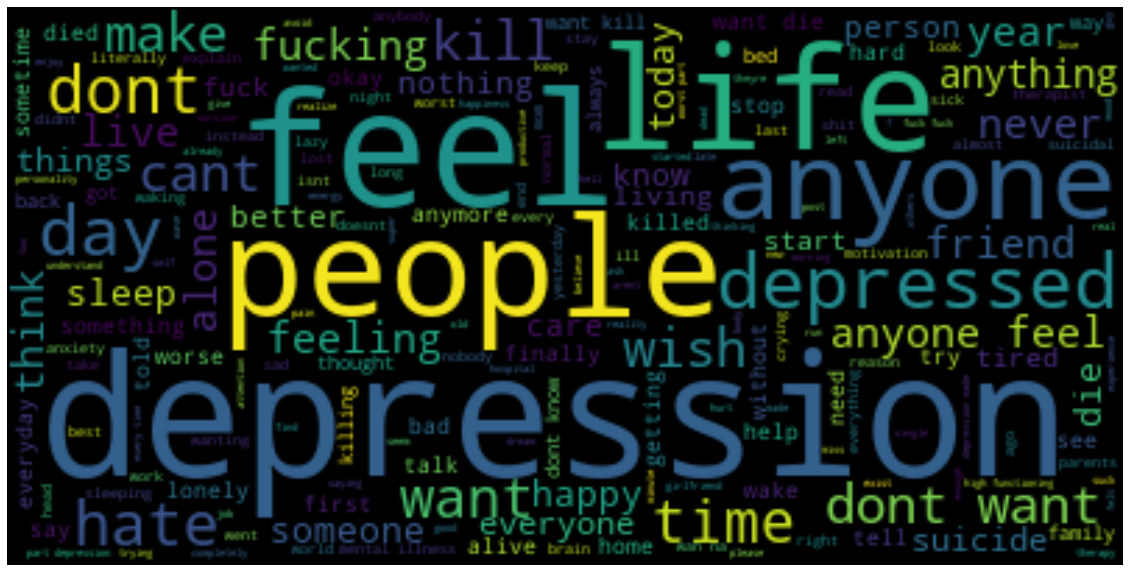

In [33]:
wordcloud_for_title = WordCloud(random_state=0).generate(words_for_wordcloud)

plt.figure(figsize = (20,20))
plt.imshow(wordcloud_for_title, interpolation='bilinear')
plt.axis("off")
plt.show()

## 해석:

우울증에 대한 커뮤니티이므로 당연히 토픽인 depression이 가장 많이 언급되는 것으로 보인다. life(인생)에 대해서 얘기를 많이 하는 것 같은데 여기서 life(목숨)으로도 해석될 수 있을 것 같다. people(사람)에 대해서도 많이 얘기를 하는 것으로 보인다. feel을 보았을 때 대부분의 글들이 자기의 기분이나 느낌을 드러내는 것으로 유추해볼 수도 있다. anyone은 주로 does anyone ~ ? 처럼 질문형으로 많이 쓰이는데 다른 사람들의 의견들을 많이 물어보는 것 같다. suicide, kill, depressed, dont, tired 처럼 매우 부정적인 단어들이 많이 보인다. 상당히 작게 나와있지만 그나마 긍적적으로 보이는 단어들은 happy나 friend 정도이다. 이처럼 대부분의 글들은 부정적인 내용의 글들일 것이다. 하지만 간혹 긍정적인 글들도 쓰일 것 같다. 다음 장에서 보일 감성분석을 통해 이를 알아보자.

## 2. Post들의 비지도학습 감성 분석

#### 위에서 사용하는 데이터와 같이 레이블이 없는 경우 비지도학습을 사용한다. 비지도학습 감성 분석인 경우, Lexicon(감성만을 분석하기 위해 지원하는 감성 어휘 사전 - 감성 사전)을 이용해서 해당 감성을 예측하는 것이다. 본 프로젝트에선 이러한 Lexicon들 중 VADER를 사용한다. VADER는 소셜미디어의 감성 분석 용도로 특화되어 있다.

이 파트는 '파이썬 머신러닝 완벽 가이드, 권철민'을 참고하였다.

### 감성지수 판단 함수

In [34]:
def vader_polarity(writing, threshold): #threshold: 긍정/부정을 결정 짓는 임계값
    analyzer = SentimentIntensityAnalyzer()
    scores = analyzer.polarity_scores(writing)
    
    #compound는 negative, neutral, positive score들을 적절히 조합해 -1에서 1사이의 감성 지수를 표현한 값
    #compound 값에 기반해 threshold 입력값보다 크면 1, 그렇지 않으면 0을 반환
    agg_score = scores['compound']
    final_sentiment = 1 if agg_score >= threshold else 0
    
    return final_sentiment  
    

In [35]:
#apply lambda 식을 이용해 레코드별로 vader_polarity()를 수행하고 결과를 'vader_preds'에 저장
df['vader_preds'] = df['body'].apply(lambda x: vader_polarity(x, 0.9)) #threshold = 0.9, 수치가 너무 낮으면 정확도가 떨어질 것 같다

## 결과

In [36]:
collections.Counter(df['vader_preds'])

Counter({0: 831, 1: 138})

#### 얼마나 정확한지 몇몇 글들을 살펴보자

In [37]:
positive_df = df[df['vader_preds']==1]['body'].reset_index()

In [38]:
for i in range(0,len(positive_df),int(len(positive_df)/5)):
    print(positive_df['body'][i],end='\n\n')

i woke up today wanting to die i was planning on doing it after school so i decided school was pointless to go to i walked to the mall by my school and went to a kneaders and ordered french toast french toast has always been my favorite so i figured it would be a good last thing to eat i pondered a ton about my life and what it is i really want i felt super empty but also my mind was racing with thoughts i had convinced myself i needed to finish my life today i had been thinking for about half an hour when an elderly man sat across from me and gave me a hot chocolate he said that he ordered it for me because he could tell i needed it he told me i dont know what youre going through but life will get better and then he left and then i cried and now im back at school and i think i want to live edit thank you to everyone who responded to this and messaged me and just were so kind  

a good friend of mine with whom ive been attending therapy for bpd overdosed a couple days ago she survived 

#### threshold를 0.9로 주니 정확도가 어느정도 나아진 것 같다. 그 이하는 너무 성능이 좋지 않았다. 확실히 그래도 이 글들 자체가 긍정과 부정으로 이분법적으로 나누기가 좀 애매해서 그런 것 같기도 하다. 결과는, r/depression에서 긍정적인 내용도 올라온다는 것이다. 주로 우울했었는데 이러한 사건으로 기분이 좋아졌다던가 우울증을 극복하고 싶다는 글들이 긍정적으로 나타난 것 같다.

## 3-1. Document Clustering(문서 군집화)

#### 문서 군집화는 비슷한 텍스트 구성의 문서를 군집화하는 것이다. 이는 비지도학습 기반으로 동작하기에 본 프로젝트의 데이터에 쓰기에 적합하다.

이 파트도 '파이썬 머신러닝 완벽 가이드, 권철민'을 참고하였다.

#### 여기서 Lemmatization은 동사나 부사같은 단어들을 원형으로 바꾸어 주는 작업이다.

In [39]:
from nltk.stem import LancasterStemmer, WordNetLemmatizer
lemmer = WordNetLemmatizer()

def LemTokens(tokens):
    return [lemmer.lemmatize(token) for token in tokens]

remove_punct_dict = dict((ord(punct), None) for punct in string.punctuation)

def LemNormalize(text):
    return LemTokens(nltk.word_tokenize(text.lower().translate(remove_punct_dict)))

In [40]:
#n-gram range: unigram, bigram, trigram
tfidf_vect = TfidfVectorizer(tokenizer=LemNormalize, stop_words='english', ngram_range=(1,3), min_df=0.05, max_df=0.85)

### Title을 기준으로 군집화하자

In [41]:
feature_vect = tfidf_vect.fit_transform(df['title'])

In [42]:
from sklearn.cluster import KMeans

#n_clusters로 군집의 개수를 정하자
km_cluster = KMeans(n_clusters=5, max_iter=1000, random_state=0)
km_cluster.fit(feature_vect)
cluster_label = km_cluster.labels_

In [43]:
df['cluster_label'] = cluster_label

## 결과

In [44]:
df.head()

,title,body,timestamp,vader_preds,cluster_label
0,depression for me is a constant feeling of wan...,its a constant sense of wanting to go somewher...,2019-08-13 13:50:20,0,2
1,depression is so much worse if you live with y...,i cant hide i cant cry out loud they dont unde...,2019-06-20 04:25:08,0,3
2,shout out to the particular hell that is funct...,this is me dont get me wrong its better than d...,2019-07-15 00:53:40,0,3
3,a stranger just saved my life,i woke up today wanting to die i was planning ...,2017-12-16 11:40:29,1,4
4,i was going to kill myself tonight,i wrote a suicide note earlier in the morning ...,2019-05-25 23:16:10,1,0


### 군집별로 확인해보자, title을 통해서 판단하자

In [45]:
df_0 = df[df['cluster_label']==0].reset_index()
print('Total number of cluster 0: ',len(df_0),end='\n\n')
for i in range(0,len(df_0),int(len(df_0)/10)):
    print(df_0['title'][i])

Total number of cluster 0:  543

i was going to kill myself tonight
too depressed to be productive and not depressed enough to kill myself
do you ever lay there in the dark just staring into the nothingness and then  hours went by somehow and you cant remember if you fell asleep or not
its lonely
everyday i wake up and my first thought is i wish i was dead
 years old with absolutely no friends
i did it guys not a big deal in the grand scheme of things but i cleaned my house
sometimes i wish i killed myself when i was 
they say money doesnt buy happiness but its extremely hard to stay happy when youre broke
i am really sorry for people who post here and nobody replies
anyone else here have no real hobbiesgoalsinterests and justs waste time on reddityoutubeetc 


#### cluster 0은 정확한 기준이 보이지 않는다, 또한 군집화 된 제목들의 수치가 유난히 큰 것으로 보아 cluster 0은 잘 군집화되진 않은 것 같다.

In [46]:
df_1 = df[df['cluster_label']==1].reset_index()
print('Total number of cluster 1: ',len(df_1),end='\n\n')
for i in range(0,len(df_1),int(len(df_1)/10)):
    print(df_1['title'][i])

Total number of cluster 1:  133

does anyone ever feel okay for a while then a wave of depression just hits you like a truck
i feel like im getting stupider less talented clumsier and that soon i will be completely retarded
i hate when you finally start to feel a bit better in life but then a bout of depression crashes down like a wave
anyone else just feel bored of everything
im begging somebody to read this i desperately need to feel like i have a friend there for me right now
i almost feel like i shouldve killed myself a long time ago and now im just living out a life that wasnt meant to happen
the saddest people always try their hardest to make people happy because they know what its like to feel absolutely worthless and they dont want anyone to feel like that
depression feels like dying before your body has died
the worst thing isnt being alone its being surrounded by people and them making you feel alone
i hate lying on bed all day being unproductivebut its the only thing i feel 

#### cluster 1은 'feel'이란 단어가 자주 보인다.

In [47]:
df_2 = df[df['cluster_label']==2].reset_index()
print('Total number of cluster 2: ',len(df_2),end='\n\n')
for i in range(0,len(df_2),int(len(df_2)/10)):
    print(df_2['title'][i])

Total number of cluster 2:  99

depression for me is a constant feeling of wanting to go home but no matter where i am i am never home even when im at my physical home
ive just started answering no when people ask if im okay
im so fucking tired of begging for help i need help being ignored is why im going to wind up dead
i think about suicide everyday but im not planning it
after three months of almost crippling depression i finally had the courage to call and make an appointment with a therapist and im very proud of myself 
i need constant background noise youtube watching series because im afraid of being alone with my own thoughts going to sleep is scary because i dont know how ill feel in the morning
im always amazed at how much energy healthy people have
im  and dont think ill survive adulthood
today im finally throwing away my suicide note
im  and my mom just died
im a  yr old white girl diagnosed by a psychologist with depression


#### cluster 2는 'im'이 자주 보인다.

In [48]:
df_3 = df[df['cluster_label']==3].reset_index()
print('Total number of cluster 3: ',len(df_3),end='\n\n')
for i in range(0,len(df_3),int(len(df_3)/10)):
    print(df_3['title'][i])

Total number of cluster 3:  114

depression is so much worse if you live with your parents
 years since i dropped out of college due to anxiety and depression i finally signed back up for classes yesterday
anger as a symptom of depression need to be recognized more
i hate that depression can just sleep for a while and then come back up full force
depression turned me into an idiot
my depression gets worse during the holidays
every time you open up about depression people always feel the need to invalidate it
i wish i could re-do my teenage years without my anxiety and depression
does anyone elses depression get worse when it starts to get late
do you think depression has reduced your mental abilities and affected your decision making skills
did your anxiety give you depression or am i just fucked


#### cluster 3은 'depression'이 자주 보인다.

In [49]:
df_4 = df[df['cluster_label']==4].reset_index()
print('Total number of cluster 4: ',len(df_4),end='\n\n')
for i in range(0,len(df_4),int(len(df_4)/10)):
    print(df_4['title'][i])

Total number of cluster 4:  80

a stranger just saved my life
i  f got dressed and did a bit of my makeup to meet up with a friend at a coffee shop im in the middle of a depressive episode and dealing with some great difficulties in my personal life she didnt show up this was my attempt to reach out
i often fantasize about something tragic happening to me so i have a reason to be depressed or dont have to participate in life for a little while
literally the only thing in my life keeping me from going completely off the rails is my cat
i cant believe i am stuck in this body for the rest of my life
the most depressing part about turning  is when you start thinking this really is my life after all
do you ever just lie in bed thinking how different your life could be and imagining all the possibilities instead of actually going out there and doing them
im a lazy pitiful  year old man child that never amounted to anything in his life in debt no degree lives with his mom and can never follow

#### cluster 4는 'life'가 자주 보인다.

### 개인적으로 hyperparameter를 튜닝하며 여러 결과를 봤지만, 이 결과가 가장 군집화가 잘된 것 같다.

## 3-2. 군집별 핵심 단어 추출

#### 각 군집은 핵심 단어를 주축으로 군집화가 되었을 것이다. 따라서 이들의 핵심 단어가 무엇인지 살펴볼 필요가 있다.

이 파트도 '파이썬 머신러닝 완벽 가이드, 권철민'을 참고하였다.

In [50]:
#군집별 top n개의 핵심 단어를 반환
def get_cluster_details(cluster_model, cluster_data, feature_names, clusters_num, top_n_features = 10):
    cluster_details = {}
    
    #cluster_centers array의 값이 큰 순으로 정렬된 인덱스 값을 반환
    #군집 중심점(centroid)별 할당된 word 피처들의 거리값이 큰 순으로 값을 구하기 위함
    centroid_feature_ordered_ind = cluster_model.cluster_centers_.argsort()[:, ::-1]
    
    #개별 군집별로 반복하면서 핵심 단어, 그 단어의 중심 위치 상댓값, 대상 파일명 입력
    for cluster_num in range(clusters_num):
        #개별 군집별 정보를 담을 데이터 초기화
        cluster_details[cluster_num] = {}
        cluster_details[cluster_num]['cluster'] = cluster_num
        
        #cluster_centers_.argsort()[:, ::-1]로 구한 인덱스를 이용해 top n개의 피처 단어를 구함
        top_feature_indexes = centroid_feature_ordered_ind[cluster_num, :top_n_features]
        top_features = [feature_names[ind] for ind in top_feature_indexes]

        cluster_details[cluster_num]['top_features'] = top_features

    return cluster_details

In [51]:
feature_names = tfidf_vect.get_feature_names()
cluster_details = get_cluster_details(cluster_model=km_cluster, cluster_data=df, feature_names=feature_names,
                                      clusters_num=5,top_n_features=5)

## 결과

In [52]:
for i in range(len(cluster_details)):
    print(cluster_details[i],end='\n')

{'cluster': 0, 'top_features': ['just', 'want', 'dont', 'people', 'depressed']}
{'cluster': 1, 'top_features': ['feel', 'like', 'feel like', 'doe', 'depression']}
{'cluster': 2, 'top_features': ['im', 'just', 'depressed', 'people', 'depression']}
{'cluster': 3, 'top_features': ['depression', 'doe', 'people', 'just', 'feel']}
{'cluster': 4, 'top_features': ['life', 'just', 'im', 'depression', 'want']}


#### 위에서 군집화된 제목들을 직접 본 결과와 같이 cluster1은 feel, cluster2는 im, cluster3은 depression, cluster4는 life가 각 군집별 핵심 단어인 것 같다. 여기서 cluster0은 다른 군집들 보다 just나 want가 핵심 단어로 추정이 되어 있다. 하지만 cluster0에 상당 수가 몰린 것을 보면 그렇게 유의한 결과 같지는 않다. 그리고 모두 공통적으로 비슷한 단어들이 자주 쓰인 것을 알 수 있다.

## 결론

#### 1. r/depression의 제목에서 자주 쓰이는 단어들을 보면 당연히 'depression': 우울증에 대해 많이 이야기를 하는 것을 알 수 있었고, 'people': 사람에 대해서, 'life': 인생에 대해서, 그리고 'feel': 자신의 감정 등의 대해서 이야기를 하는 글들이 많은 것을 알 수 있었다.

#### 2. 글들의 내용의 비지도학습 감성분석을 통해 비록 대부분의 글들이 부정적인 내용들이었지만 긍정적인 글들도 쓰인 것을 알 수 있었다.

#### 3. 글들의 제목들을 통해서 의미 있는 군집화가 가능하였고 'feel': 기분과 감정에 대한 글, 'im': 자신에 대한 글, 'depression': 우울증을 직접 언급하는 글, 'life': 인생,목숨에 대한 글로 군집화가 되는 것을 알 수 있었다.